This notebook is a custom annotated notebook based on [PyTorch DQN Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import matplotlib

# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Create Replay Buffer

The Replay Buffer is used to store transitions and then sample from it, which increases stability. The replay buffer consists of tuples $(s, a, r, s^{\prime})$ being state, action, reward and next state respectively. This tuple is named a `Transition` in the code below.

In [6]:
import random
from collections import namedtuple, deque

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q-Learning Network (DQN)

## The Goal of DQN

For DQN, given that we are in some state $s$, the goal is to find an optimal policy $\pi^*(s)$ that takes the action associated with the greatest reward if we were to follow that policy $\pi^*$. This means that we can express the optimal policy as $\pi^*=\argmax Q^*(s, a)$, where $s$ is the state and $a$ is the action. The goal of the neural network is to approximate $Q^*$ as best as possible.

## Update Function

Updating the policy is done by assigning a new $Q$-value to a state-action combination under the current policy $\pi$, i.e. updating $Q^{\pi}(s, a)$. This update consists of two terms:

1. The first term is the direct reward $r$ of taking action $a$ in state $s$. These values will be stored in a __policy network__.
2. The second term is a recursive definition of the policy for taking action $a$ in state $s$, but applied to the next action $a^{\prime}$ and next state $s^{\prime}$. This value is muliplied by a discount factor $\gamma$ to control how much (distant) future rewards contribute. These values will be stored in a __target network__ because $r + \gamma Q^{\pi}(s^{\prime}, \pi(s^{\prime}))$ is called a temporal difference (TD) __target__.

The final update rule looks as follows:

$\begin{equation}
Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s^{\prime}, \pi(s^{\prime}))
\end{equation}$

In conclusion, $Q(s, a)$ is referred to as the __policy network__ and $r + \gamma\max_a Q(s^{\prime}, a^{\prime})$ as the __target network__.

## Policy Network & Target Network

There are two networks at play:
1. The policy network is updated after each step. This can be observed in the code where the parameters of `policy_net`, i.e. `policy_net.parameters()` are passed to the optimizer `AdamW`, which is then used after each step by a call to `optimizer.step()`.
2. The target network on the other hand is used to keep the $Q$-values stable. This is motivated by the fact that you affect the state-action value of the next state you will be in when you update the weights of the $Q$-network after taking the current step (as opposed to non-deep $Q$-learning where updates only affect your current state). The target network is therefore updated only every once in a while (this is usually a hyperparameter).

## Loss

Given the aforementioned update function, we can consider the different before and after the update as an __error__. If we assign this error to a new variable $\delta$ we get:

$\begin{equation}
  \delta = Q(s, a) - (r + \gamma\max_a Q(s^{\prime}, a^{\prime}))
\end{equation}$

# Q-Network

The Q-Network below is the PyTorch implementation of a deep learning network with three layers. The first layer takes the number of observations and maps it to a second, hidden layer. The hidden layer is then mapped to the number of actions.

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self, n_observations: int, n_actions: int):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x: torch.Tensor):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training DQN

## CartPole Environment

In [8]:
import gymnasium as gym

env = gym.make("CartPole-v1")

## Utilities & Hyperparameters

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Optimization Step

The optimization step samples a batch from the replay buffer and then computes the following values:

1. The current value of taking action $a$ in state $s$ using the policy network, i.e. $Q(s, a)$
2. The best action to take according to our policy $Q$, i.e. $\max_a Q(s_{t+1}, a)$ for all next states
3. The loss between the policy network values and the target network (expected, discounted, future) values

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Training Loop

Complete


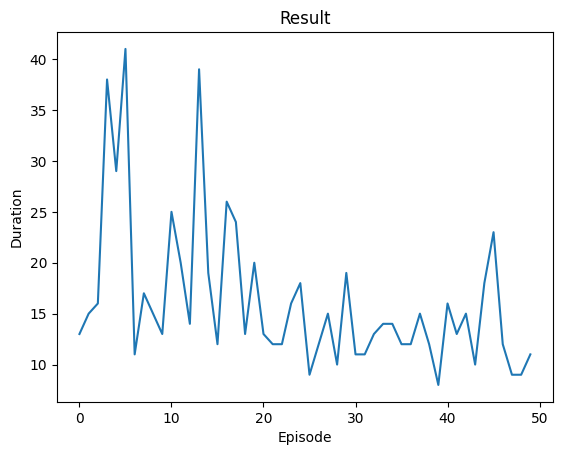

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
from itertools import count

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print("Complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()